# Goal

* Map incorporators on the phylogeny

# Setting variables

In [61]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [62]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/Replicates/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqSIP = 'SIP-core'
physeqBulk = 'bulkSIP-core' 

l2fcResFile = os.path.join(workDir, 'l2fc_sparse-maxRejH_Day30Reps.txt')

padj_cutoff = 0.1   # adjusted p-value cutoff for selecting incorporators
nprocs = 14

# Init

In [63]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)

In [64]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

if not os.path.isdir(figDir):
    os.makedirs(figDir)

/home/chantal/Chazy/Chazy_SIP/data/Replicates


In [65]:
%%R -i workDir -i figDir -i physeqDir -i physeqSIP -i physeqBulk  -i l2fcResFile -i padj_cutoff -i nprocs 
cat('variables loaded into R\n')

variables loaded into R


# Loading files

In [66]:
%%R 

F = file.path(physeqDir, physeqSIP)
physeq.SIP = readRDS(F)
physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21115 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21115 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21115 tips and 21114 internal nodes ]


In [67]:
%%R 

F = file.path(physeqDir, physeqBulk)
physeq.bulk = readRDS(F)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Treatment != "H2O",
                           physeq.bulk)
physeq.bulk.m = physeq.bulk %>% sample_data

physeq.bulk = prune_samples(physeq.bulk.m$Treatment == '13C'& physeq.bulk.m$Replicate != 1, physeq.bulk) 

physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16187 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 16187 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16187 tips and 16186 internal nodes ]


In [68]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(l2fcResFile, sep='\t')
df.l2fc %>% head(n=3)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C  30         2             NTH OTU.4163     -1.8293704 0.8776045
2       13C  30         2             NTH OTU.5493      0.1896905 0.5152681
3       13C  30         2             NTH OTU.1739      1.2306254 0.1049658
  padj    Rank1            Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria    __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria    __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria __Planctomycetes __OM190 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.72        1.75               0.05
2  <NA>  <NA>        1.72        1.75               0.05
3  <NA>  <NA>        1.72        1.75               0.05


In [69]:
%%R
n_incorps = df.l2fc %>%
    filter(padj <= padj_cutoff) %>%
    distinct(OTU) %>% 
    nrow

cat('Number of incorporators:', n_incorps, '\n')

Number of incorporators: 2230 


## Making tree plot & metadata plots separately, then combining with grid.arrange

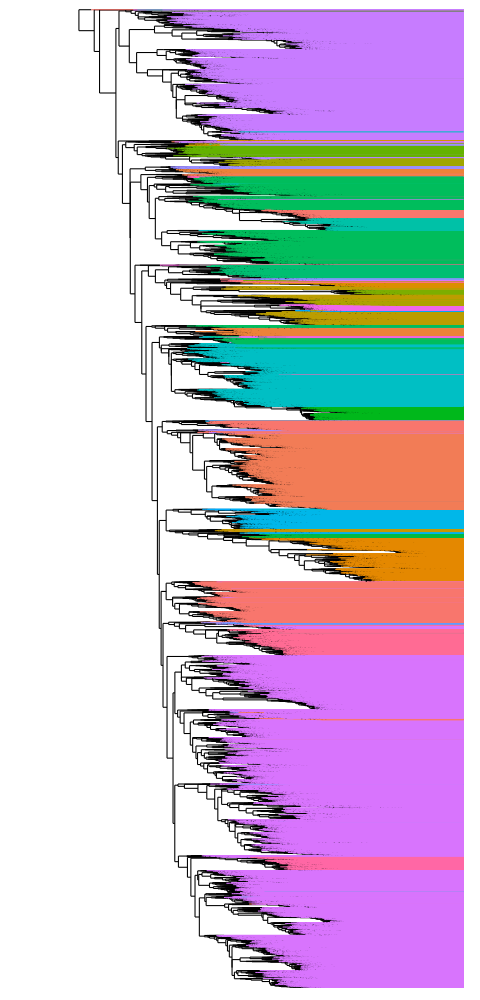

In [70]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4, ret.tax=FALSE){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # if just needing to return taxonomy order
    if(ret.tax==TRUE){
        return(edge_otu.con)
    }
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin,
            rect = element_rect(fill = "transparent",colour = NA)
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(physeq.SIP, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

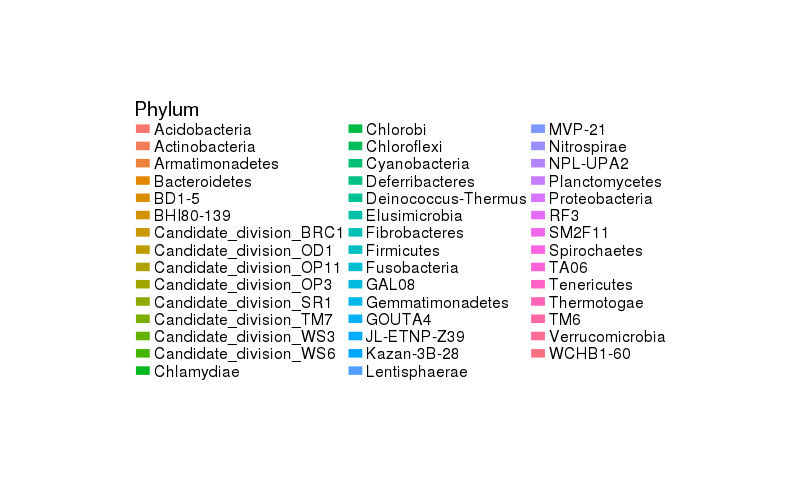

In [71]:
%%R -w 800

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + 
        theme(legend.position=legend.position, 
              text = element_text(size=text.size),
             panel.background = element_blank(),
              rect = element_rect(fill = "transparent",colour = NA))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

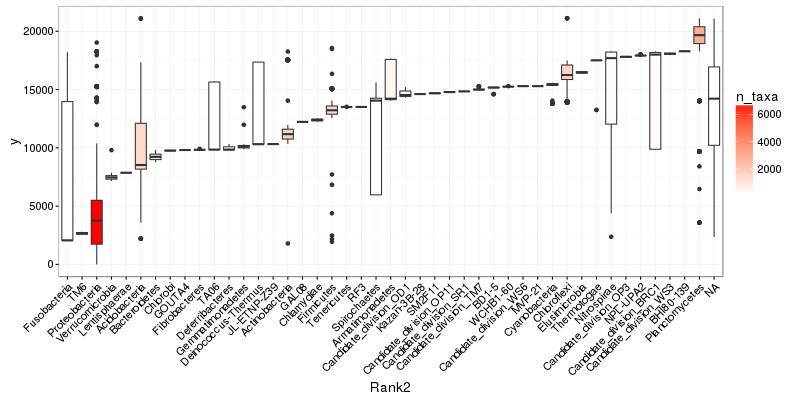

In [72]:
%%R -w 800 -h 400
# taxonomy order in the phylogeny
rank_pos = plot_tree(physeq.SIP, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'), ret.tax=TRUE) %>% 
    group_by(Rank2) %>%
    mutate(median_y = median(y),
           n_taxa=n()) %>%
    ungroup %>%
    mutate(Rank2 = reorder(Rank2, median_y))

## plotting
ggplot(rank_pos, aes(Rank2, y, fill=n_taxa)) +
    geom_boxplot() +
    scale_fill_gradient(low='white', high='red') +
    theme_bw() +
    theme(
        text = element_text(size=14),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [73]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                dplyr::select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    dplyr::select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(physeq.SIP, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

       OTU y.tree Treatment Day Replicate Land_Management log2FoldChange
1 OTU.4940  21115       13C  30         3             PTH     -0.5437572
2 OTU.4940  21115       13C  30         4             PTH     -0.5069062
3 OTU.4940  21115       13C  30         2             PTH     -0.8276844
4 OTU.4940  21115       13C  30         4             NTH      0.6566043
          p padj density_min density_max sparsity_threshold
1 0.6806839    1        1.72        1.75               0.05
2 0.6814828    1        1.72        1.75               0.05
3 0.7360377    1        1.74        1.77               0.05
4 0.3846157    1        1.74        1.77               0.05


In [74]:
%%R 

# calc wUnifrac distance
calc.wunif.dist = function(physeq, cores=8){
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }


# ordering substrates by w-unifrac distances between incorporators
order_substrates_by_incorps = function(metadata, physeq, padj.cutoff=0.1, method='average', ...){
   
    # filtering physeq to just incorporators
    incorps = metadata %>%
        filter(padj <= padj.cutoff)
    taxa.names = taxa_names(physeq)
    taxa.to.rm = taxa.names[taxa.names %in% incorps$OTU]
    physeq.cut = prune_taxa(taxa.to.rm, physeq)
    
    # merging samples by substrate
    physeq.cut.merge = merge_samples(physeq.cut, "Treatment")
    
    # removing 12C-con
    physeq.md = physeq.cut.merge %>% sample_data
    physeq.md$Treatment = rownames(physeq.md)
    sample_data(physeq.cut.merge) = physeq.md
    physeq.cut.merge = prune_samples(physeq.md$Treatment!= '12C', physeq.cut.merge)
        
    # w-unifrac
    wunif.dist = calc.wunif.dist(physeq.cut.merge, ...)
        
    # hclust of w-unifrac values
    wunif.clust = hclust(wunif.dist, method=method)
    
    # ordering metadata by hclust ordering
    substrates = metadata$Substrate %>% as.vector %>% unique
    substrates = substrates[wunif.clust$order]
    metadata$Substrate = factor(metadata$Treatment, levels=substrates)
    
    return(metadata)
}

#-- test --#
#calc.wunif.dist(physeq.thresh, cores=20)
df.l2fc.ord2 = order_substrates_by_incorps(df.l2fc.ord, physeq.SIP, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree Treatment Day Replicate Land_Management log2FoldChange
1 OTU.4940  21115       13C  30         3             PTH     -0.5437572
2 OTU.4940  21115       13C  30         4             PTH     -0.5069062
3 OTU.4940  21115       13C  30         2             PTH     -0.8276844
4 OTU.4940  21115       13C  30         4             NTH      0.6566043
          p padj density_min density_max sparsity_threshold Substrate
1 0.6806839    1        1.72        1.75               0.05      <NA>
2 0.6814828    1        1.72        1.75               0.05      <NA>
3 0.7360377    1        1.74        1.77               0.05      <NA>
4 0.3846157    1        1.74        1.77               0.05      <NA>


In [75]:
%%R
n_incorps = df.l2fc.ord2 %>% 
    filter(padj <= padj_cutoff) %>% 
    distinct(OTU) %>% nrow

cat('Number of incorporators:', n_incorps, '\n')

Number of incorporators: 2098 


In [76]:
%%R
df.l2fc.ord2$ls = paste(df.l2fc.ord2$Treatment, df.l2fc.ord2$Land_Management, sep = "-")

Number of incorporators: 2098 
Number of incorporator instances: 3932 


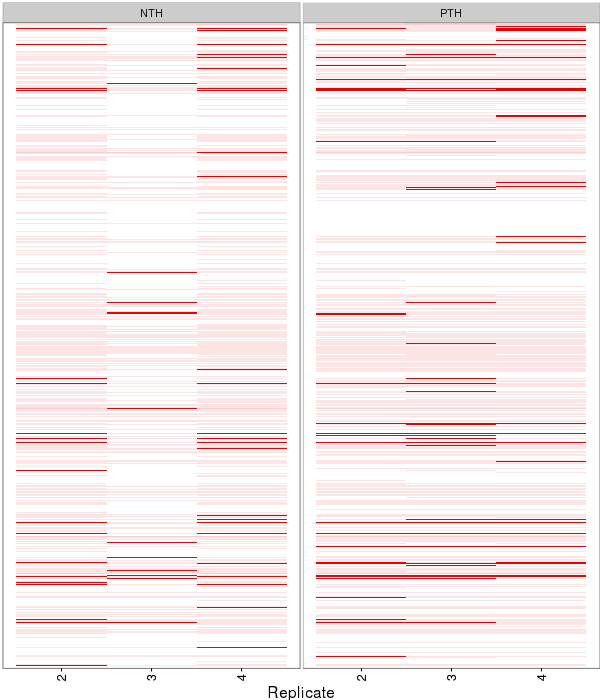

In [77]:
%%R -w 600 -h 700

# function for making incorporator plot

incorp_plot = function(metadata, plot.margin=NULL, strip.text.x.size=11, padj_cutoff=0.1){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }
    
    metadata.ord = metadata %>%
        mutate(incorporator = padj <= padj_cutoff,
               incorporator.num = incorporator %>% as.numeric,
               Day = Day %>% as.character)
    
    metadata.ord$Day = reorder(metadata.ord$Day, metadata.ord$Day %>% as.numeric)

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    


    # coloring
    metadata.ord.p = metadata.ord %>%
        filter(incorporator == TRUE) %>%
        mutate(Day = Day %>% reorder(Day %>% as.numeric))
    #inc.cols = c('darkblue', 'blue', 'dodgerblue', 'orange', 'yellow3', 'yellow', 'grey', 'black')
    # 1, 14, 3, 30, 48, 6
    #inc.cols = colorRampPalette(c("red3", "blue"))
    #inc.cols = inc.cols(6)[c(1,4,2,5,6,3)]
    inc.cols = rep('red2', 10)
    inc.cols = c(inc.cols, 'grey', 'black')
    
    # status
    n_incorps = metadata.ord %>% 
        filter(incorporator == TRUE) %>% 
        distinct(OTU) %>% nrow
    cat('Number of incorporators:', n_incorps, '\n')
    n_incorp_X = metadata.ord %>% 
        filter(incorporator == TRUE) %>% nrow
    cat('Number of incorporator instances:', n_incorp_X, '\n')       
    
    # line-wrapping
    p.incorp = ggplot(metadata.ord, aes(Replicate, y.tree, fill=incorporator, alpha=incorporator.num)) +
        geom_tile() +
        geom_tile(data=metadata.ord.p, aes(fill=as.factor(Replicate))) +
        scale_fill_manual(values=inc.cols) +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Land_Management, scales='free_x', space='free_x') +
        theme_bw() +
        theme(
            text = element_text(size=16),
            strip.text.x = element_text(size=strip.text.x.size),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin,
            panel.margin = unit(1, 'mm'),
            panel.background = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
            )   
    return(p.incorp)
    

    }
    

#-- test --#
p.incorp = incorp_plot(df.l2fc.ord2, padj_cutoff=padj_cutoff)
p.incorp

### Making OTU bulk soil abundance plots

In [78]:
%%R

bulk_abund_plot_df = function(physeq, l2fc.ord){
    # creating a df for making bulk soil abundance plots
    # physeq = physeq ob bulk soil samples
    physeq.m = physeq %>% sample_data
    physeq.f = prune_samples(physeq.m$Treatment == '13C', physeq)
    physeq.f.m = physeq.m %>% sample_data %>% as.data.frame
    
    ## OTU table
    tbl.otu = physeq.f %>% otu_table %>% as.data.frame
    tbl.otu$OTU = rownames(tbl.otu)
    n.col = ncol(tbl.otu)
    print(head(tbl.otu))
    tbl.otu = gather(tbl.otu, 'sample', 'count', 1:(n.col-1)) %>%
        group_by(OTU) %>%
        mutate(count_byOTU_norm = count / sum(count) * 100) %>%          
        group_by(sample) %>%
        mutate(count_byComm_norm = count / sum(count) * 100) %>%
        ungroup
    
    ##Grouping by treatment
    
   
    
    ## joining with metadata & filtering
    df.bulk = inner_join(tbl.otu, physeq.f.m, c('sample' = 'Full.sample')) 
    
    ## adding tree location info
    l2fc.ord.d = l2fc.ord %>%
        select(OTU, y.tree) %>%
        distinct()
    df.bulk.j = left_join(l2fc.ord.d,  df.bulk, c('OTU' = 'OTU')) %>%
        mutate(Day = Day %>% as.character,
               Day = ifelse(is.na(Day), 1, Day),
               count = ifelse(is.na(count), 0, count),
               count_byOTU_norm = ifelse(is.na(count_byOTU_norm), 0, count_byOTU_norm),
               count_byComm_norm = ifelse(is.na(count_byComm_norm), 0, count_byComm_norm)) 
    
    return(df.bulk.j)
    }

df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
df.bulk %>% head(n=3)

          13C.NTH.Day3.Rep2 13C.PTH.Day7.Rep3 13C.NTH.Day14.Rep4
OTU.4940                  0                 0                  0
OTU.4163                  0                 0                  0
OTU.5493                  0                 0                  0
OTU.1739                  0                 0                  1
OTU.1813                  0                 0                  0
OTU.27780                 0                 0                  0
          13C.NTH.Day14.Rep2 13C.NTH.Day7.Rep2 13C.NTH.Day7.Rep3
OTU.4940                   0                 0                 0
OTU.4163                   0                 1                 0
OTU.5493                   0                 0                 0
OTU.1739                   0                 1                 0
OTU.1813                   0                 1                 0
OTU.27780                  0                 0                 0
          13C.PTH.Day7.Rep2 13C.PTH.Day3.Rep3 13C.PTH.Day3.Rep2
OTU.4940                  

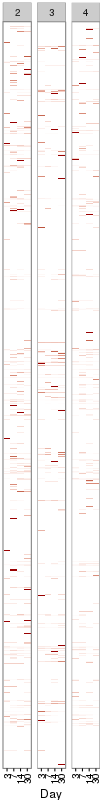

In [79]:
%%R -w 100 -h 800
    
bulk_rel_abund_plot = function(df, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }
    
    df$Day = reorder(df$Day, df$Day %>% as.numeric)
    df$Bulk = 'Bulk soil'
    
    df = filter(df, !(is.na(Till)))
    
    p.abund = ggplot(df, aes(Day, y.tree, fill=count_byOTU_norm)) +
        geom_tile(stat='identity') +
        scale_fill_continuous(low='#FFFFFF', high='#990000',na.value='grey80') +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Replicate) +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin,
            panel.background = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
            ) 
    return(p.abund)
    }

p.rel.abund = bulk_rel_abund_plot(df.bulk)
p.rel.abund

          13C.NTH.Day3.Rep2 13C.PTH.Day7.Rep3 13C.NTH.Day14.Rep4
OTU.4940                  0                 0                  0
OTU.4163                  0                 0                  0
OTU.5493                  0                 0                  0
OTU.1739                  0                 0                  1
OTU.1813                  0                 0                  0
OTU.27780                 0                 0                  0
          13C.NTH.Day14.Rep2 13C.NTH.Day7.Rep2 13C.NTH.Day7.Rep3
OTU.4940                   0                 0                 0
OTU.4163                   0                 1                 0
OTU.5493                   0                 0                 0
OTU.1739                   0                 1                 0
OTU.1813                   0                 1                 0
OTU.27780                  0                 0                 0
          13C.PTH.Day7.Rep2 13C.PTH.Day3.Rep3 13C.PTH.Day3.Rep2
OTU.4940                  

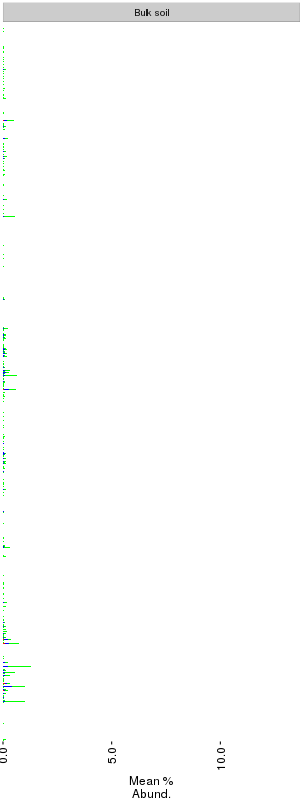

In [80]:
%%R -w 300 -h 800

bulk_rel_total_abund_plot = function(df, 
                                     plot.margin=NULL, bar.width=3, 
                                     round.digits=0,
                                     scale.y.log10=FALSE){
    # function for plotting abundances of taxa relative to whole community
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }
    
    # summing counts
    df.s = df %>%
           group_by(OTU, y.tree) %>%  
           summarize(min_count_byComm_norm = min(count_byComm_norm),
                mean_count_byComm_norm = mean(count_byComm_norm),
                max_count_byComm_norm = max(count_byComm_norm)) %>% 
           ungroup()

    df.s$Bulk = 'Bulk soil'
    
    # digit formating
    print.f = paste(c('%.', round.digits, 'f'), collapse='')
    
    # plotting
    p.abund = ggplot(df.s, aes(y.tree, shape='-')) +
        scale_x_continuous(expand=c(0,0)) +
        facet_grid(. ~ Bulk) +    
        coord_flip() +
        theme_bw() +
        labs(y='Mean %\nAbund.') +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title.x = element_text(size=12),
            axis.text.x = element_text(size=12, angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            panel.border = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin,
            panel.background = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
            ) 
    if(scale.y.log10){
        p.abund = p.abund + 
            scale_y_log10(expand=c(0,0)) +
            geom_point(aes(y=max_count_byComm_norm), color='darkgreen') + 
            geom_point(aes(y=mean_count_byComm_norm), color='blue') +
            geom_point(aes(y=min_count_byComm_norm), color='red') 
    } else {
        p.abund = p.abund +
            scale_y_continuous(expand=c(0,0), label=function(x) sprintf(print.f, round(x, round.digits))) +
            geom_bar(aes(y=max_count_byComm_norm), stat='identity', width=bar.width, fill='green') + 
            geom_bar(aes(y=mean_count_byComm_norm), stat='identity', width=bar.width, fill='blue') +
            geom_bar(aes(y=min_count_byComm_norm), stat='identity', width=bar.width, fill='red') 
    }
    return(p.abund)
    }

#-- test --#
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 

                           
total_counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame      
                           
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, round.digits=1) 
p.rel.total.abund

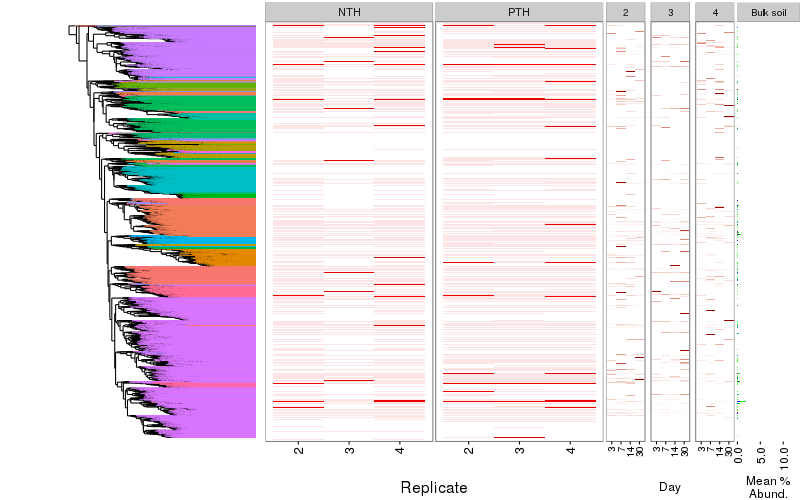

In [81]:
%%R -w 800 -h 500
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

#-- test --#
x = resize_ggplots(list(p.tree, p.incorp, p.rel.abund, p.rel.total.abund), 
                   widths=c(1,1.3,0.5,0.25))
do.call(grid.arrange, x)

Number of incorporators: 2098 
Number of incorporator instances: 3932 
          13C.NTH.Day3.Rep2 13C.PTH.Day7.Rep3 13C.NTH.Day14.Rep4
OTU.4940                  0                 0                  0
OTU.4163                  0                 0                  0
OTU.5493                  0                 0                  0
OTU.1739                  0                 0                  1
OTU.1813                  0                 0                  0
OTU.27780                 0                 0                  0
          13C.NTH.Day14.Rep2 13C.NTH.Day7.Rep2 13C.NTH.Day7.Rep3
OTU.4940                   0                 0                 0
OTU.4163                   0                 1                 0
OTU.5493                   0                 0                 0
OTU.1739                   0                 1                 0
OTU.1813                   0                 1                 0
OTU.27780                  0                 0                 0
          13C.PTH.D

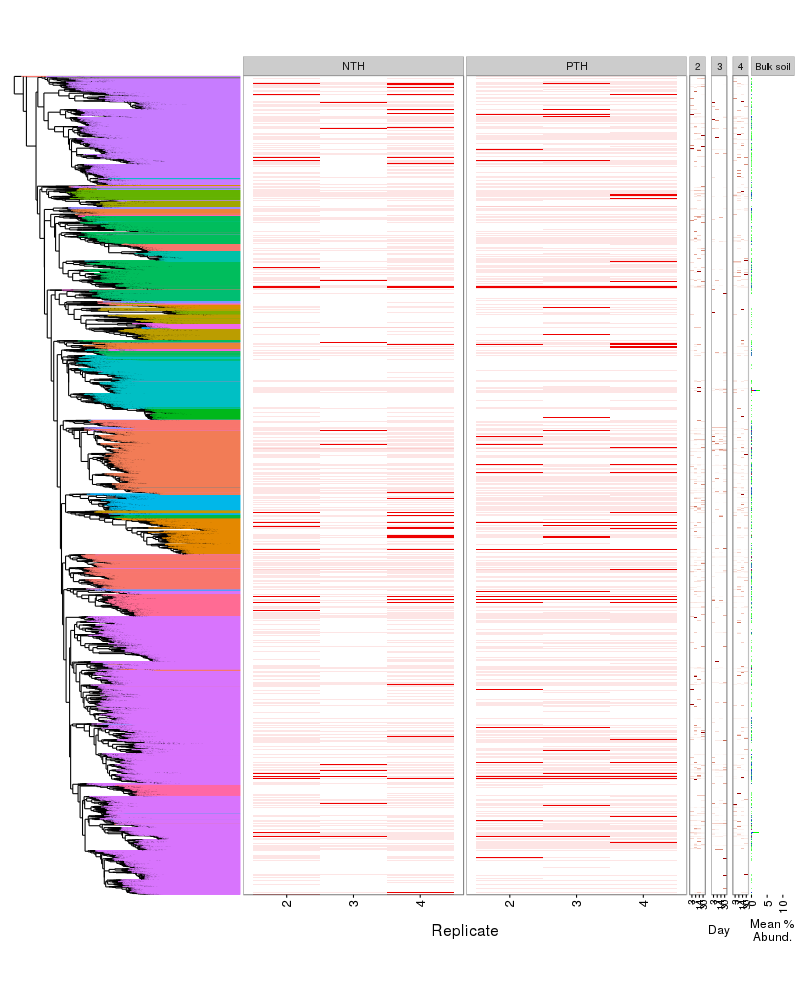

In [82]:
%%R -w 800 -h 1000
# tree plot
p.tree = plot_tree(physeq.SIP, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.4,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.s$ls = paste(df.l2fc.s$Treatment, df.l2fc.s$Land_Management, sep = "-")
df.l2fc.ord = order_metadata_to_tree(physeq.SIP, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.SIP, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,0), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, 
                                              plot.margin=unit(c(2,0.2,2,0), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

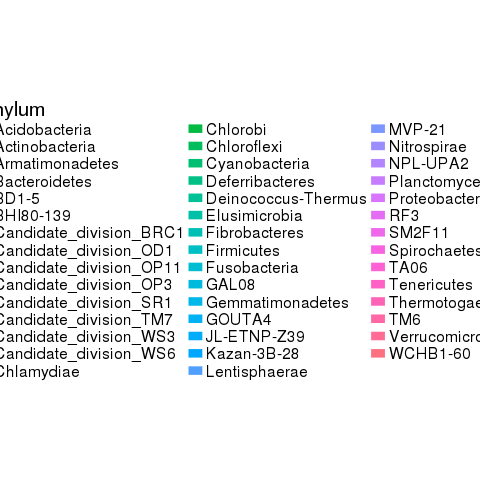

In [83]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

## full tree; just incorporators

In [84]:
%%R
# adding incorporator status to tax_table

physeq.SIP.inc = physeq.SIP
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Incorporator = any(padj <= padj_cutoff) %>% as.numeric) %>%
    ungroup() 


tax = physeq.SIP.inc %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, df.l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Incorporator = ifelse(is.na(Incorporator), 0, Incorporator)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

# making new phyloseq object with incorporator info
physeq.SIP.inc = phyloseq(physeq.SIP.inc %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.SIP.inc %>% sample_data,
                             physeq.SIP.inc %>% phy_tree)
physeq.SIP.inc = subset_taxa(physeq.SIP.inc, Incorporator==1)
physeq.SIP.inc

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2098 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 2098 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2098 tips and 2097 internal nodes ]


Number of incorporators: 2098 
Number of incorporator instances: 3932 
          13C.NTH.Day3.Rep2 13C.PTH.Day7.Rep3 13C.NTH.Day14.Rep4
OTU.4940                  0                 0                  0
OTU.4163                  0                 0                  0
OTU.5493                  0                 0                  0
OTU.1739                  0                 0                  1
OTU.1813                  0                 0                  0
OTU.27780                 0                 0                  0
          13C.NTH.Day14.Rep2 13C.NTH.Day7.Rep2 13C.NTH.Day7.Rep3
OTU.4940                   0                 0                 0
OTU.4163                   0                 1                 0
OTU.5493                   0                 0                 0
OTU.1739                   0                 1                 0
OTU.1813                   0                 1                 0
OTU.27780                  0                 0                 0
          13C.PTH.D

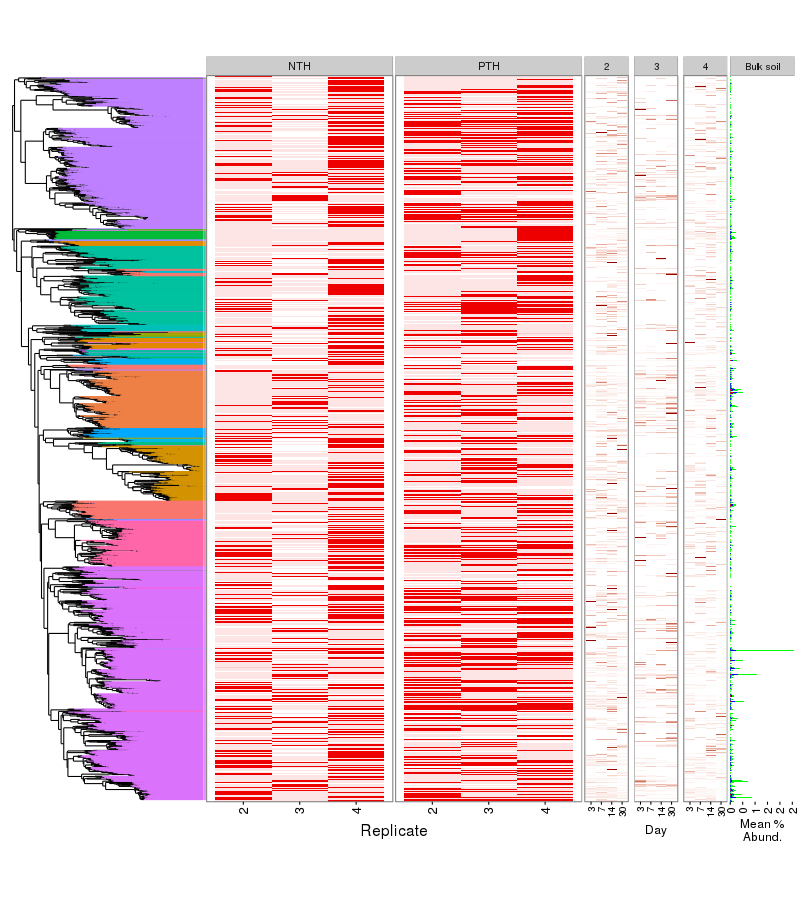

In [85]:
%%R -w 800 -h 900

p.tree = plot_tree(physeq.SIP.inc, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.4,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
df.l2fc.s$ls = paste(df.l2fc.s$Treatment, df.l2fc.s$Land_Management, sep = "-")

## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.SIP.inc, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.SIP.inc, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,0), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1.25, 
                                              plot.margin=unit(c(2,0.2,2,0), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.50,0.25))
do.call(grid.arrange, gt)

In [86]:
%%R
# saving figure
outFile = 'allPhyla-inc_sparCut0.25.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


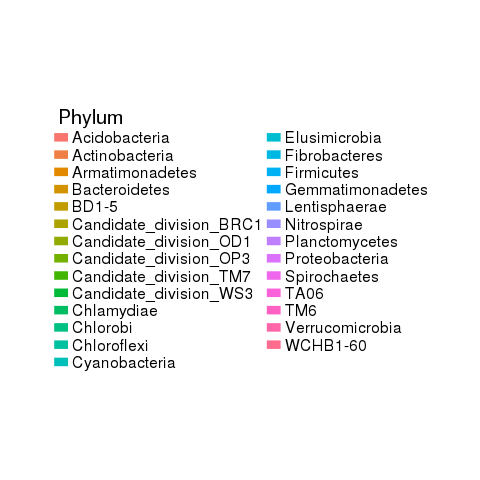

In [87]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [88]:
%%R 
# saving legend
outFile = 'allPhyla-inc_sparCut0.3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


### full tree; just incorporators; manual order of substrates

In [89]:
%%R -w 800 -h 900

p.tree = plot_tree(physeq.SIP.inc, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.15,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.SIP.inc, df.l2fc.s) 
## substrates by similarity of incorporators
#df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.SIP.inc, cores=nprocs)
substrate.ord = c('13C-Ami', '13C-Glu', '13C-Gly', '13C-Xyl', '13C-Lac', 
                  '13C-Oxa', '13C-Van', '13C-Cel', '13C-Pal')
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=substrate.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, strip.text.x.size=11)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,0), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1.25, 
                                              plot.margin=unit(c(2,0.2,2,0), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp, p.rel.abund, p.rel.total.abund),
                    widths=c(0.22,1.5,0.18,0.15))
do.call(grid.arrange, gt)


Error in `$<-.data.frame`(`*tmp*`, "Substrate", value = integer(0)) : 
  replacement has 0 rows, data has 10749


In [90]:
%%R
# saving figure
# outFile = 'allPhyla-inc_wBulk_sparCutMax.pdf'
# outFile = file.path(figDir, outFile)
# pdf(outFile, width=800 / 60, height=900 / 60)
# do.call(grid.arrange, gt)
# dev.off()
# cat('File written:', outFile, '\n')

NULL


### Simple plot: not bulk abundance data

Number of incorporators: 2098 
Number of incorporator instances: 3932 


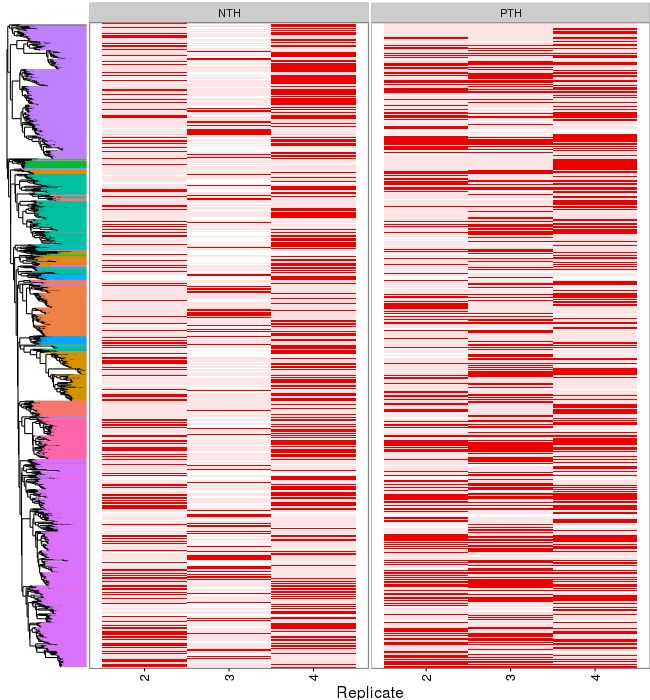

In [91]:
%%R -w 650 -h 700

p.tree = plot_tree(physeq.SIP.inc, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.15,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.SIP.inc, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.SIP.inc, method='median', cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),
                    widths=c(0.2,1.3))
do.call(grid.arrange, gt)

In [92]:
%%R
# saving figure
# outFile = 'allPhyla-inc_sparCutMax.pdf'
# outFile = file.path(figDir, outFile)
# pdf(outFile, width=673 / 65, height=800 / 65)
# do.call(grid.arrange, gt)
# dev.off()
# cat('File written:', outFile, '\n')

NULL


In [93]:
%%R 
# saving legend
# outFile = 'allPhyla-inc_sparCutMax_leg.pdf'
# outFile = file.path(figDir, outFile)
# pdf(outFile, width=500 / 65, height=500 / 65)
# my.legend = g_legend(p.tree)
# grid.draw(my.legend)
# dev.off()
# cat('File written:', outFile, '\n')

NULL
